# Search: Solving a Maze Using a Goal-based Agent


## Instructions

Total Points: Undegraduates 10, graduate students 11

Complete this notebook and submit it. The notebook needs to be a complete project report with 

* your implementation,
* documentation including a short discussion of how your implementation works and your design choices, and
* experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. 

Use the provided notebook cells and insert additional code and markdown cells as needed.


## Introduction

The agent has a map of the maze it is in (i.e., the environment is deterministic, discrete, and known). The agent must use the map to plan a path through the maze from the starting location $S$ to the goal location $G$.  

This is a planing exercise for a goal-based agent, so you do not need to implement an environment, just use the map to search for a path. Once the plan is made, the agent can just follow the path and does not need percepts. The execution phase is trivial and we do not implement it in this exercise.

Tree search algorithm implementations that you find online and used in general algorithms courses have often a different aim. These algorithms assume that you already have a tree and the goal is to traverse all nodes. We are interested in dynamically creating a search tree with the aim of finding a good/the best path to the goal state. Follow the pseudo code presented in the text book closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible. 

Here is the small example maze:

In [1]:
f = open("small_maze.txt", "r")
maze_str = f.read()
print(maze_str)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX



__Note:__ The mazes above contains cycles and therefore search may not form proper trees unless cycles are prevented. You need to deal with cycle detection in your code.

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the file [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation.

In [68]:
%run maze_helper.py

maze = parse_maze(maze_str)

# look at two positions in the maze
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)`
print("Position(8,1):", look(maze, (8, 1)))
print(maze_str)
print(len(maze), len(maze[0]))

Position(0,0): X
Position(8,1): G
XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX

10 22


Visualize the maze

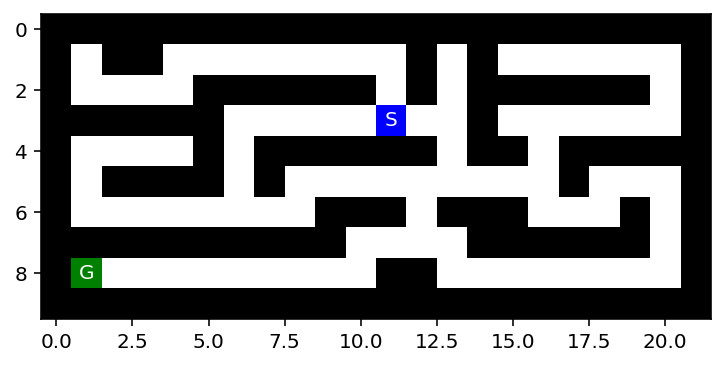

In [69]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

show_maze(maze)

Find the position of the start and the goal using the helper function `find_pos()`

In [4]:
print("Start location:", find_pos(maze, what = "S"))
print("Goal location:", find_pos(maze, what = "G"))

Start location: (3, 11)
Goal location: (8, 1)


## Tree structure

Implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73):

In [5]:
class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search

    def __str__(self):
        return f"Node - pos = {self.pos}; parent = {repr(self.parent)}; action = {self.action}; cost = {self.cost}"

Example: Create the root node and append the node for going east with a cost of 1.

In [6]:
print("Create root node")
root = Node(pos = (0,0), parent = None, action = None, cost = 0)
print("root:", root)
print("root (reference):", repr(root))

print()
print("Go east with cost 1 (from the parent root)")
node2 = Node(pos = (0,1), parent = root, action = "E", cost = 1)
print("node2:", node2)
print("parent of node2: ", node2.parent)
print("parent of node2 (reference): ", repr(node2.parent))

print()
print("Note that the root note is safe from garbage collection as long as we have a reference in node2") 
root = None
print(root)
print("parent of node2 (reference): ", repr(node2.parent))

print()
print("Once we release node2, the whole tree is deleted.")
node2 = None

Create root node
root: Node - pos = (0, 0); parent = None; action = None; cost = 0
root (reference): <__main__.Node object at 0x000001A9245A4888>

Go east with cost 1 (from the parent root)
node2: Node - pos = (0, 1); parent = <__main__.Node object at 0x000001A9245A4888>; action = E; cost = 1
parent of node2:  Node - pos = (0, 0); parent = None; action = None; cost = 0
parent of node2 (reference):  <__main__.Node object at 0x000001A9245A4888>

Note that the root note is safe from garbage collection as long as we have a reference in node2
None
parent of node2 (reference):  <__main__.Node object at 0x000001A9245A4888>

Once we release node2, the whole tree is deleted.


# Goal
Implement the following search algorithms for solving different mazes:

* Breadth-first search (BFS)
* Depth-first search (DFS)
* Iterative deepening search (IDS)
* Greedy best-first search (GBFS)
* A* search

Run each of the above algorithms on the 
[small maze](small_maze.txt), 
[medium maze](medium_maze.txt), 
[large maze](large_maze.txt), 
[open maze](open_maze.txt),
[wall maze](wall_maze.txt),
[loops maze](loops_maze.txt),
[empty maze](empty_maze.txt), and
[empty 2_maze](empty_2_maze.txt).
For each problem instance and each search algorithm, report the following in a table:

* The solution and its path cost
* Number of nodes expanded
* Maximum tree depth searched
* Maximum size of the frontier.

Display each solution by marking every maze square (or state) visited and the squares on the final path.

## Task 1: Defining the search Problem [1 point]

Define the components of the search problem:

* **Initial state**: the square in the maze that contains an S
* **Actions**: 
 * West: col - 1
 * East: col + 1
 * Norht: row - 1
 * South: row + 1
* **Transition model**: Perform the operation corresponding to the action aboce
* **Goal state**: The square with S in it
* **Path cost**: Each square costs 1 to move to

<div style="background-color:rgba(0, 0, 0, 0.0470588); padding:10px 0;font-family:monospace;">
function BFS(problem) returns a solution<br>
&nbsp;&nbsp;node := NODE(problem, initial)<br>
&nbsp;&nbsp;if problem.isGoal(node.state) then reutrn node<br>
&nbsp;&nbsp;frontier := a (general) queue, with a node as an element<br>
&nbsp;&nbsp;reached := problem.initial<br>
&nbsp;&nbsp;while not isEmpty(frontier):<br>
&nbsp;&nbsp;&nbsp;&nbsp; node := pop(frontier)<br>
&nbsp;&nbsp;&nbsp;&nbsp; for each child in expand(problem, node) do<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; s := child.state<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; if problem.isGoal(s) then return child<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; if s is not in reached then:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; add s to reached<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; add child to frontier<br>
&nbsp;&nbsp; return failure<br>
<br>
<br>
function Expand(problem, node) yields nodes:<br>
&nbsp;&nbsp;s := node.state<br>
&nbsp;&nbsp;for each action in problem.Actions(s) do:<br>
&nbsp;&nbsp;&nbsp;&nbsp;s' := problem.result(s, action)<br>
&nbsp;&nbsp;&nbsp;&nbsp;cost := node.path - cost + problem.actionCost(s, action.s')<br>
&nbsp;&nbsp;&nbsp;&nbsp;Node(state=s', parent-node, action = action, pathCost=cost)<br>
</div>

## Task 2: Breadth-first and Depth-first [4 points]

Implement these search strategies. Note that the algorithms for BFS and DFS are very different! Make sure that DFS uses less memory by releasing nodes that are not needed anymore. 

In [182]:
# Your code goes here
# Expand will return a list of nodes that we can go to from the current node
#class Node:
#    def __init__(self, pos, parent, action, cost):

from collections import deque

def expand(node, maze):
    options = []
    h = len(maze)
    w = len(maze[1])
    can_go_north = node.pos[0] - 1 >= 0 and maze[node.pos[0] - 1, node.pos[1]] != 'X'
    can_go_south = node.pos[0] + 1 < h and maze[node.pos[0] + 1, node.pos[1]] != 'X'
    can_go_east = node.pos[1] + 1 < w and maze[node.pos[0], node.pos[1]+1] != 'X'
    can_go_west = node.pos[1] -1 >= 0 and maze[node.pos[0], node.pos[1]-1] != 'X'
    if can_go_north:
        new_node = Node((node.pos[0] - 1, node.pos[1]), node, 'N', node.cost+1)
        options.append(new_node)
    if can_go_south:
        new_node = Node((node.pos[0] + 1, node.pos[1]), node, 'S', node.cost+1)
        options.append(new_node)
    if can_go_east:
        new_node = Node((node.pos[0], node.pos[1] + 1), node, 'E', node.cost+1)
        options.append(new_node)
    if can_go_west:
        new_node = Node((node.pos[0], node.pos[1] - 1), node, 'W', node.cost+1)
        options.append(new_node)
    
    return options

def get_path(node):
    if node.parent is None:
        return ''
    return print_path(node.parent) + ' ' + node.action
    
    
    
def generic_best_first_search(maze, node, search_type = 'breadth'):
    # stats for performance mesure
    nodes_expanded = 1
    max_tree_depth = 1
    max_tree_size = 1
    max_frontier_size = 1
    if maze[node.pos[0], node.pos[1]] == 'G':
        return node
    frontier = deque() # LIFO or FIFO depending on Breadth or Depth
    frontier.append(node)
    reached = {} # set of visited nodes. For efficency this needs to be a hash set
    while not len(frontier) == 0:
        next_node = None
        if search_type == 'depth':
            next_node = frontier.pop()
        else:
            next_node = frontier.popleft()
        if maze[next_node.pos[0]][next_node.pos[1]] == 'G':
            return (next_node,
                    nodes_expanded,
                    max_tree_depth,
                    max_tree_size,
                    max_frontier_size)
        
        nodes_expanded += 1
        childs = expand(next_node, maze)
        had_child = False
        for child in childs:
            if child.pos not in reached or child.cost < reached[child.pos].cost:
                if child.pos not in reached:
                    max_tree_size += 1
                had_child = True
                reached[child.pos] = child
                frontier.append(child)
                max_frontier_size = max(len(frontier), max_frontier_size)
                max_tree_depth = max(max_tree_depth, child.cost)
        if not had_child:
            max_tree_size -= 1
            next_node = None
    return None
    
    

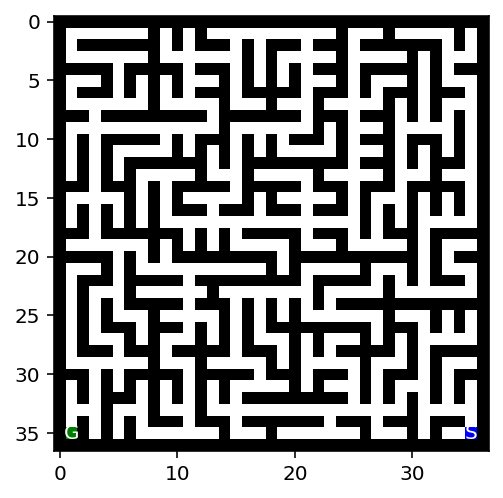

breadth first search path
Nodes Expanded: 622,  Max Tree Depth: 210,  Max Tree Size: 532,  Max Frontier Size: 8
 N N W W W W N N W W S S W W W W W W W W W W W W W W N N E E N N W W N N N N N N E E E E E E S S E E N N E E E E N N E E S S E E N N N N N N E E E E N N N N N N N N N N W W S S W W W W S S S S S S W W S S S S W W N N W W W W W W W W W W W W N N E E N N N N N N E E E E E E N N N N N N N N W W W W W W S S W W W W S S S S E E S S W W W W W W W W W W S S S S S S S S S S E E S S S S W W S S S S E E S S W W S S S S W W S S
breadth first search path
Nodes Expanded: 392,  Max Tree Depth: 222,  Max Tree Size: 388,  Max Frontier Size: 38
depth first search path
 N N W W W W N N W W S S W W W W W W W W W W W W W W N N E E N N W W N N N N N N E E E E E E S S E E N N E E E E N N E E S S E E N N N N N N E E E E N N N N N N N N N N W W S S W W W W S S S S S S W W S S S S W W N N W W W W W W W W W W W W N N E E N N N N N N E E E E E E N N N N N N N N W W W W W W S S W W W W S S S S E E S S W

In [183]:
# Run fit on some mazes to test
f = open("large_maze.txt", "r")
maze_str = f.read()

maze = parse_maze(maze_str)

show_maze(maze)
find_pos(maze, what= 'S')
#print("Start location:", find_pos(maze, what = "S"))
initial_node = Node(find_pos(maze, what= 'S'), None, None, 0)
output = generic_best_first_search(maze, initial_node, search_type = 'breadth')
node = output[0]
print('breadth first search path')
print(f'Nodes Expanded: {output[1]}, ',
      f'Max Tree Depth: {output[2]}, ',
      f'Max Tree Size: {output[3]}, ',
      f'Max Frontier Size: {output[4]}')
print(get_path(node))

initial_node = Node(find_pos(maze, what= 'S'), None, None, 0)
output = generic_best_first_search(maze, initial_node, search_type = 'depth')
node = output[0]
print('breadth first search path')
print(f'Nodes Expanded: {output[1]}, ',
      f'Max Tree Depth: {output[2]}, ',
      f'Max Tree Size: {output[3]}, ',
      f'Max Frontier Size: {output[4]}')
print('depth first search path')
print(get_path(node))



**How do you deal with loops (cycles)?**

To deal with cycles, I kept a dictionary of reached states. Since a state is a position the dictionary maps position to a number, that represents the cost to get there. If another path gets to that state at a cheaper cost, it will replace that in the dictionary. 

**Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations?**

Breadth-First-Search
* Complete: If there is a solution this implementation of Breadth-Frist-Search will find it.
* Optimal: Since the algorithm will go level by level, it garentees that it will find the path that costs the least

Depth-First-Search
* Complete: If there is a solution this implentation of Depth-First-Search will find it. 
* Optimal: Since it will expand each path until failure, it will return the first solution it finds, and the example above even shows an example that does not return the optimal solution


## Task 3: Implement greedy best-first search and A* search  [4 points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function.

In [11]:
# Your code goes here

Are your implementations complete and optimal? What is the time and space complexity?

In [12]:
# Discussion

## Task 4: Comparison and discussion [2 points] 

Run experiments to compare the implemented algorithms and present the results as tables and charts.

In [13]:
# Add code, table, charts.

Complete the following table for each maze.

__Small maze__

| algorithm | path cost | nodes expanded | max tree depth | max tree size | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |           |                |                |               |                   |
| DFS       |           |                |                |               |                   |
| GBS       |           |                |                |               |                   |
| A*        |           |                |                |               |                   |

__Medium Maze__

...

Discuss the most important lessons you have learned from implementing the different search strategies. 

In [14]:
# Add discussion

## Graduate student advanced task: Multiple Goals [1 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+1 Bonus point].

Create a few mazes with multiple goals by adding a one or two more goals to the medium sizes maze.
Solve the maze with your implementations for DFS, BFS, and implement IDS (iterative deepening search using DFS). Run experiments to show which implementations find the optimal solution.

In [15]:
# Your code/answer goes here

## More advanced tasks to think about

Instead of defining each square as a state (which you probably did), use only intersections as states. Now the storage requirement is reduced, but the path length between two intersections can be different. If we use total path length in number of squares as path cost, how can we make sure that BFS and iterative deepening search is optimal? Change the code to do so.

In [16]:
# Your code/answer goes here

Modify your A* search to add weights (see text book) and explore how different weights influence the result.

In [17]:
# Your code/answer goes here

What happens if the agent does not know the layout of the maze in advance (i.e., faces an unkown, only partially observable environment)? How does the environment look then (PEAS description)? How would you implement a rational agent to solve the maze? What if the agent still has a GPS device to tell the distance to the goal?

In [18]:
# Your code/answer goes here